<H1><center>New York City TLC Trip Taxi
<br>--------
<br><center>Data Analysis

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings 
warnings.filterwarnings("ignore")

# Setting max column
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 35)

In [98]:
df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-2\data\processed\data_clean.csv")
df = df.astype({
    'pickup_datetime': 'datetime64[s]',
    'dropoff_datetime': 'datetime64[s]'
})
df

,pickup_datetime,dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_population,DO_population,PU_density,DO_density
0,2023-01-01 00:26:10,2023-01-01 00:26:21,11.02,2.580000,14.05,1,1,14.90,1.0,0.5,4.03,0.0,1.0,2.75,24.18,1,1,Manhattan,Manhattan,Morningside Heights,Lincoln Square West,1575590,1575590,75492.477273,75492.477273
1,2023-01-01 00:51:03,2023-01-01 00:51:09,6.77,1.810000,16.04,1,1,10.70,1.0,0.5,2.64,0.0,1.0,0.00,15.84,1,1,Manhattan,Manhattan,Bloomingdale,Central Park,1575590,1575590,75492.477273,75492.477273
2,2023-01-01 00:35:12,2023-01-01 00:35:18,6.33,0.000000,0.00,1,1,7.20,1.0,0.5,1.94,0.0,1.0,0.00,11.64,1,1,Queens,Queens,Steinway,Old Astoria,2233270,2233270,26896.305085,26896.305085
3,2023-01-01 00:13:14,2023-01-01 00:13:19,5.82,1.300000,13.40,1,1,6.50,0.5,1.5,1.70,0.0,1.0,0.00,11.20,1,1,Manhattan,Manhattan,Central Harlem,Upper West Side North,1575590,1575590,75492.477273,75492.477273
4,2023-01-01 00:33:04,2023-01-01 00:33:09,5.97,1.100000,11.06,1,1,6.00,0.5,1.5,0.00,0.0,1.0,0.00,9.00,1,1,Manhattan,Manhattan,Central Harlem,East Harlem North,1575590,1575590,75492.477273,75492.477273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67143,2023-01-31 22:29:00,2023-01-31 22:29:13,13.00,2.326428,10.74,1,1,15.70,0.0,0.0,0.00,0.0,1.0,0.00,16.70,5,3,Brooklyn,Brooklyn,Clinton Hill,Crown Heights South,2504700,2504700,41710.864865,41710.864865
67144,2023-01-31 22:40:00,2023-01-31 22:40:08,8.00,2.140000,16.05,1,1,4.41,0.0,0.0,0.00,0.0,1.0,0.00,5.41,5,3,Queens,Queens,Baisley Park,Saint Albans,2233270,2233270,26896.305085,26896.305085
67145,2023-01-31 23:46:00,2023-01-31 23:46:16,16.00,3.440000,12.90,1,1,16.53,0.0,0.0,3.51,0.0,1.0,0.00,21.04,5,3,Brooklyn,Brooklyn,DUMBO/Vinegar Hill,Bushwick South,2504700,2504700,41710.864865,41710.864865
67146,2023-01-31 23:01:00,2023-01-31 23:01:18,18.00,3.030000,10.10,1,1,14.98,0.0,0.0,3.20,0.0,1.0,0.00,19.18,5,3,Brooklyn,Brooklyn,Stuyvesant Heights,Prospect Heights,2504700,2504700,41710.864865,41710.864865


In [99]:
pd.DataFrame(
        {
        'feature': df.columns.values,
        'data_type': df.dtypes.values,
        'total_row': df.isna().count().values,
        'total_null': df.isna().sum().values,
        '%null_value': df.isna().mean().values * 100,
        'n_unique': df.nunique().values,
        'sample_unique': [df[col].unique() for col in df.columns]
        }
    )

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,pickup_datetime,datetime64[s],67148,0,0.000000,65735,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
1,dropoff_datetime,datetime64[s],67148,0,0.000000,65973,"[2023-01-01 00:26:21, 2023-01-01 00:51:09, 202..."
2,trip_duration_minute,float64,67148,0,0.000000,3594,"[11.02, 6.77, 6.33, 5.82, 5.97, 17.55, 17.42, ..."
3,trip_distance,float64,67148,0,0.000000,1799,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."
4,avg_speed_MPH,float64,67148,6,0.008935,3489,"[14.05, 16.04, 0.0, 13.4, 11.06, 9.5, 13.09, 8..."
5,RatecodeID,int64,67148,0,0.000000,4,"[1, 5, 2, 3]"
6,passenger_count,int64,67148,0,0.000000,6,"[1, 2, 4, 3, 6, 5]"
7,fare_amount,float64,67148,0,0.000000,2470,"[14.9, 10.7, 7.2, 6.5, 6.0, 17.7, 19.1, 14.2, ..."
8,extra,float64,67148,0,0.000000,12,"[1.0, 0.5, 3.75, 0.0, 3.25, 6.0, 5.0, 2.75, 5...."
9,mta_tax,float64,67148,0,0.000000,5,"[0.5, 1.5, 0.0, 1.0, 2.75]"


## Data analysis

Kita akan melakukan analisis untuk meningkatkan jumlah pengguna taksi hijau terhadap populasi setiap borough. Analisis akan dilakukan dengan melihat di Borough mana jumlah pengguna taksi hijau tertinggi. Setelah mengetahui lokasi Borough mana yang memiliki jumlah pengguna taksi terbanyak, kemudian kita dapat menentukan seberapa besar target yang akan dicapai untuk pengguna taksi hijau. Untuk menjawab permasalahan tersebut kita dapat melihat karakteristik pengguna taksi yang telah melakukan perjalanan dengan melihat pola distribusi perjalanan setiap minggunya, pola distribusi perjalanan setiap jamnya dan jenis pembayaran. Selanjutnya hasil dari analisis dan solusi yang bisa direkomendasikan akan menjadi bahan pertimbangan untuk perusahaan dalam menentukan strategi bisnis kedepannya.

### Meningkatkan pengguna taksi berdasarkan populasi Borough yang terpilih

Untuk menjawab persoalan diatas, kita perlu menjawab pertanyaan-pertanyaan sebagai berikut:
1. Di Borough/ wilayah mana yang memiliki jumlah pengguna terbanyak?
2. Bagaimana karakteristik pengguna yang telah melakukan perjalanan menggunakan taksi hijau yang dilihat dari:
    * Dimana lokasi dropoff yang paling sering terjadi?
    * Kapan waktu yang paling sering pengguna memesan taksi?
    * Jenis pembayaran apa yang paling diminati?
    * Jenis trip seperti apa yang biasanya dilakukan oleh pengguna taksi?
3. Memberi saran dan rekomendasi yang sesuai dengan permasalahan tersebut

In [139]:
prop_df = df['PU_Borough'].value_counts().reset_index()
prop_df

,PU_Borough,count
0,Manhattan,39172
1,Queens,17609
2,Brooklyn,9179
3,Bronx,1176
4,Staten Island,12


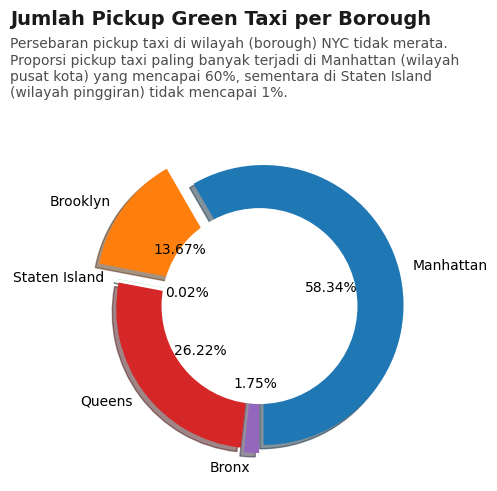

In [151]:
prop_df = df['PU_Borough'].value_counts().reset_index()
prop_df = prop_df.reindex([0, 2, 4, 1, 3])
#  set figure size
plt.style.use('default')
plt.figure(figsize=(5,6))

# create pie chart
plt.pie(prop_df['count'],
        labels=prop_df['PU_Borough'],
        autopct='%0.2f%%', 
        startangle=270, 
        pctdistance=0.5, 
        explode=(0.03, 0.2, 0.03, 0.03, 0.05),
        shadow=True
)

# create a circle at the center of the plot
fig = plt.gcf()
centre_circle = plt.Circle((0,0), 0.7, fc='white')
fig.gca().add_artist(centre_circle)
plt.tight_layout()

# set title
fig.text(
    0.02,
    0.97,
    'Jumlah Pickup Green Taxi per Borough',
    color="#1a1a1a",
    fontsize=14,
    weight="bold"
)

subtitle = [
    "Persebaran pickup taxi di wilayah (borough) NYC tidak merata.",
    "Proporsi pickup taxi paling banyak terjadi di Manhattan (wilayah",
    "pusat kota) yang mencapai 60%, sementara di Staten Island",
    "(wilayah pinggiran) tidak mencapai 1%."
]
fig.text(
    0.02,
    0.85,
    "\n".join(subtitle),
    ha="left",
    color="#4d4d4d",
    fontsize=10,
);

#### **1. Di Borough/ wilayah mana yang memiliki jumlah pengguna terbanyak?**

Untuk menjawab pertanyaan diatas, kita perlu menjawab pertanyaan berikut:
1. Berapa persen masyarakat yang menggunakan taksi dari populasi untuk setiap borough?
2. Borough/ wilayah mana yang memiliki jumlah pickup order taksi terbanyak?

In [124]:
# Potensi pasar untuk setiap Borough

# Potensi pasar dari setiap Borough Pickup
market_pot = df.groupby("PU_Borough").agg({"PU_population":"max", "passenger_count":"sum"}).reset_index()
market_pot.rename(columns={
    "PU_Borough": "Borough",
    "PU_population": "Population",
    "passenger_count": "PU_Taxi_User"
}, inplace=True)
market_pot["PU_Taxi_User_by_Population(%)"] = ((market_pot["PU_Taxi_User"] / market_pot["Population"]) * 100).round(2)
market_pot.sort_values(by="Borough", ascending=True)

# Potensi pasar dari setiap Borough Dropoff
market_pot_DO = df.groupby("DO_Borough").agg({"DO_population":"max", "passenger_count":"sum"}).reset_index()
market_pot_DO.rename(columns={
    "DO_Borough": "Borough",
    "DO_population": "Population",
    "passenger_count": "DO_Taxi_User"
}, inplace=True)
market_pot_DO["DO_Taxi_User_by_Population(%)"] = ((market_pot_DO["DO_Taxi_User"] / market_pot_DO["Population"]) * 100).round(2)
market_pot_DO.sort_values(by="Borough", ascending=True)

# Menggabungkan dua dataframe
market_pot = pd.merge(market_pot, market_pot_DO, how="outer", on="Borough")
market_pot.drop(columns="Population_y", inplace=True)
market_pot.rename(columns={"Population_x": "Population"}, inplace=True)
market_pot.fillna(0, inplace=True)

# Sort values dari nilai tertinggi
market_pot.sort_values(by="PU_Taxi_User_by_Population(%)", ascending=False, ignore_index=True)
market_pot

,Borough,Population,PU_Taxi_User,PU_Taxi_User_by_Population(%),DO_Taxi_User,DO_Taxi_User_by_Population(%)
0,Bronx,1382480.0,1342.0,0.10,2965,0.21
1,Brooklyn,2504700.0,11648.0,0.47,9611,0.38
2,Manhattan,1575590.0,52034.0,3.30,52380,3.32
3,Queens,2233270.0,22312.0,1.00,22339,1.00
4,Staten Island,468730.0,17.0,0.00,20,0.00
5,EWR,0.0,0.0,0.00,38,inf


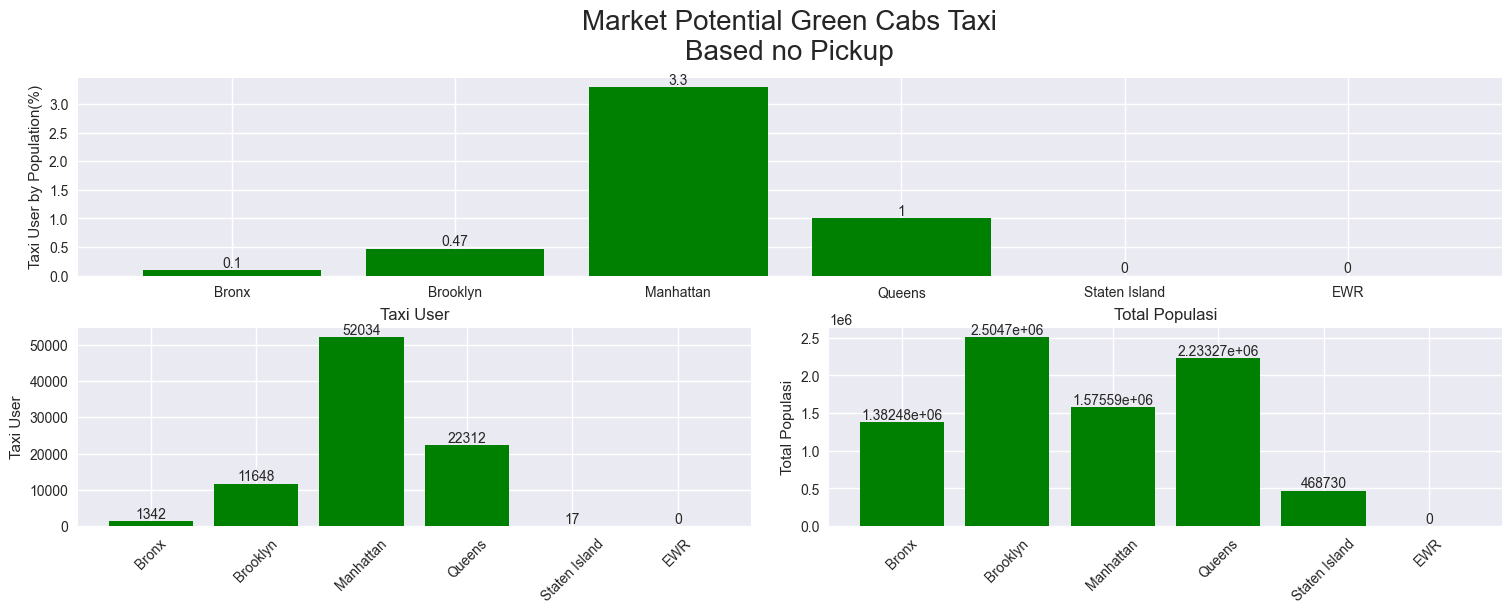

In [125]:
# Create Market Potential Chart

# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 8),
    constrained_layout=True, 
    sharex=True
)

# Boxplot Population
ax3 = plt.subplot2grid((3,2), (0,0), colspan=2)
ax3.bar(
    market_pot["Borough"],
    market_pot["Population"], color="Green"
)
ax3.set_title("Total Populasi")
ax3.set_ylabel('Total Populasi')

# Boxplot Taxi User
ax1 = plt.subplot2grid((3,2), (1,0))
ax1.bar(
    market_pot["Borough"],
    market_pot["PU_Taxi_User"], color="Green"
)
ax1.set_title("Taxi User")
ax1.set_ylabel("Taxi User")
plt.xticks(rotation=45)

labelx = -0.3  # axes coords

# Boxplot Populasi
ax2 = plt.subplot2grid((3,2), (1,1))
ax2.bar(
    market_pot["Borough"],
    market_pot["Population"], color="Green"
)
ax2.set_title("Total Populasi")
ax2.set_ylabel('Total Populasi')
plt.xticks(rotation=45)


# Boxplot Taxi User by Population
ax3 = plt.subplot2grid((3,2), (0,0), colspan=2)
ax3.bar(
    market_pot["Borough"],
    market_pot["PU_Taxi_User_by_Population(%)"], color="Green"
)
ax3.set_title("Taxi User by Population")
ax3.set_ylabel('Taxi User by Population(%)')

plt.title("Market Potential Green Cabs Taxi\nBased no Pickup", fontsize=20, y=1.05)

## annotation
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
ax3.bar_label(ax3.containers[0])

plt.show();

Dari grafik Market Potential diatas kita dapat insight:
1. Jumlah pickup order tertinggi berada di wilayah Manhattan dengan 52.034 pengguna dan ratio Taxi User by Population sebesar 3.30%. Karena Manhattan merupakan kota bagian dengan populasi tertinggi di kota New York dan menjadi pusat bisnis. Karena kota bagian Queens merupakan kota terluas di New York City
2. Jumlah pickup order tertinggi kedua berada di wilayah Queens dengan 22.312 pegguna dan ratio 1%
3. Tidak ada histori perjalanan taksi yang berasal dari wilayah EWR

Dari hasil tersebut kita dapat memfokuskan analisis kita untuk meningkatkan pengguna taksi hijau di kota bagian Manhattan dan Queens. Untuk kota bagian Manhattan coba kita tetapkan target 5% dari total populasi menggunakan taksi hijau dan kita targetkan kota bagian Queens dengan nilai 3%

#### **Target pengguna untuk setiap kota bagian**

Kita akan menghitung target pengguna untuk setiap kota bagian di New York City

In [137]:
# find the total amount from all of the member in Manhattan
current_user = df[df.PU_Borough=="Manhattan"]["passenger_count"].sum()

# find the target
target_user = (0.055 * df[df.PU_Borough=="Manhattan"]["PU_population"].max()).round(0)

# Gap user
gap_user = target_user - current_user

print(f'''Total current user green cabs in Manhattan (3.3%): {current_user}, 
The target of user to increase 5.5%: {target_user},
Gap of target and current user: {gap_user}''')

Total current user green cabs in Manhattan (3.3%): 52034, 
The target of user to increase 5.5%: 86657.0,
Gap of target and current user: 34623.0


In [136]:
# find the total amount from all of the member in Manhattan
current_user = df[df.PU_Borough=="Queens"]["passenger_count"].sum()

# find the target
target_user = (0.03 * df[df.PU_Borough=="Queens"]["PU_population"].max()).round(0)

# Gap user
gap_user = target_user - current_user

print(f'''Total current user green cabs in Queens(1%): {current_user}, 
The target of user to increase 3%: {target_user},
Gap of target and current user: {gap_user}''')

Total current user green cabs in Queens(1%): 22312, 
The target of user to increase 3%: 66998.0,
Gap of target and current user: 44686.0


**Insight:**

#### **2. Bagaimana karakteristik pengguna yang telah melakukan perjalanan menggunakan taksi hijau?**

Untuk mendukung strategi bisnis dengan meningkatkan populasi yang menggunakan taksi hijau ini, kita perlu mengetahui karakteristik dari pengguna yang melakukan perjalanan dari kota bagian Manhattan dan Queens. Berikut akan coba kita analisis karakteristik pengguna taksi tersebut.

##### **- Lokasi dropoff yang paling sering dipesan?**

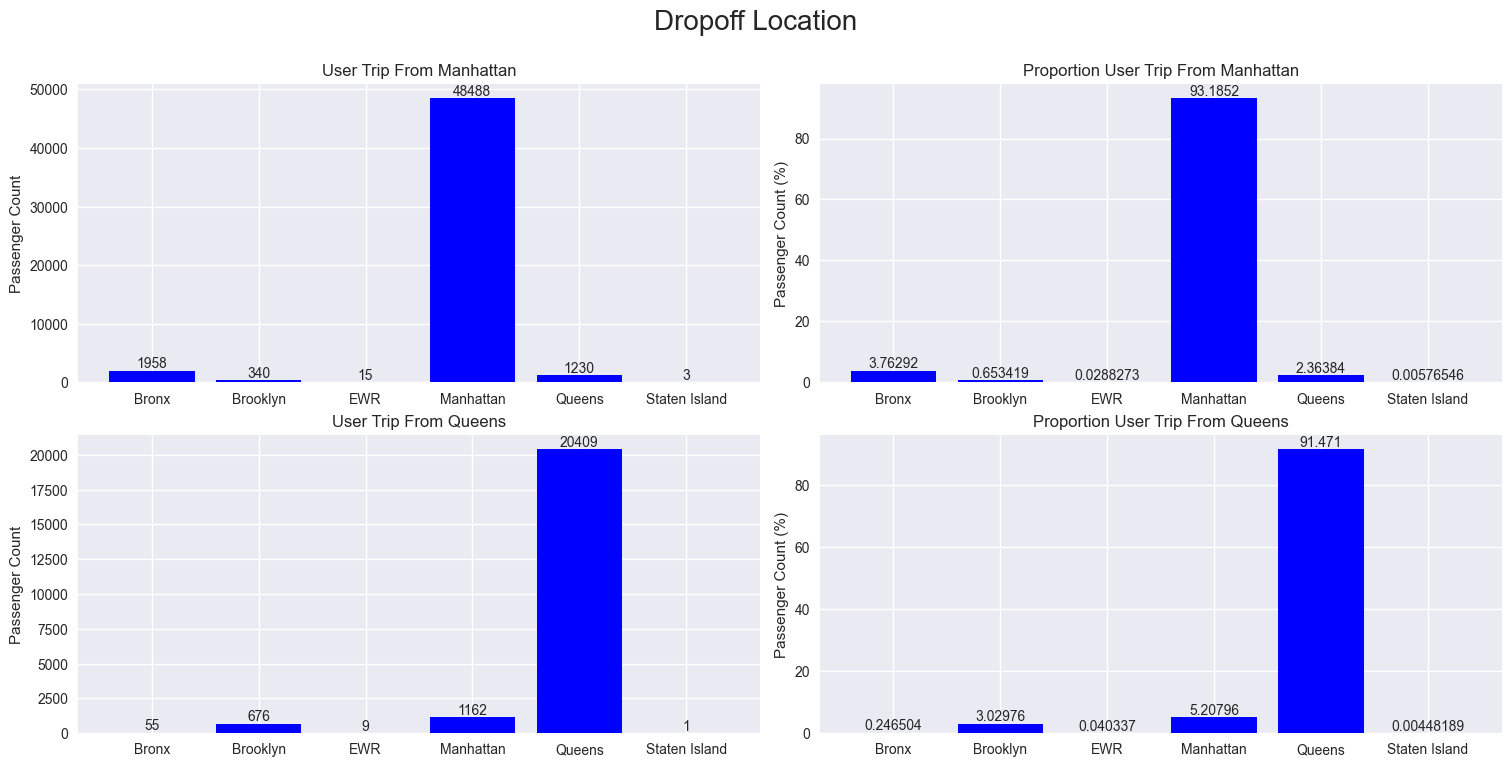

In [102]:
# Cek lokasi dropoff terbanyak untuk trip sesuai dengan lokasi pickupnya

# Create Dropoff Location

# Create dataframe trip pickup
PU_Bronx = df[df.PU_Borough == "Bronx"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Brooklyn = df[df.PU_Borough == "Brooklyn"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_EWR = df[df.PU_Borough == "EWR"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Manhattan = df[df.PU_Borough == "Manhattan"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Queens = df[df.PU_Borough == "Queens"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()
PU_Staten_Island = df[df.PU_Borough == "Staten Island"].groupby("DO_Borough").agg({"passenger_count":"sum", "total_amount":"sum"}).reset_index()


# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15,10), 
    constrained_layout=True, 
    sharex=True
)

# Trip From Manhattan
ax1 = plt.subplot2grid((3,2), (0,0));
ax1.bar(
    PU_Manhattan["DO_Borough"],
    PU_Manhattan["passenger_count"], color="Blue"
)
ax1.set_title("User Trip From Manhattan")
ax1.set_ylabel("Passenger Count")
plt.xticks(rotation=0)
# Proportion From Manhattan
ax2 = plt.subplot2grid((3,2), (0,1));
ax2.bar(
    PU_Manhattan["DO_Borough"],
    (PU_Manhattan["passenger_count"]/PU_Manhattan["passenger_count"].sum()*100), color="Blue"
)
ax2.set_title("Proportion User Trip From Manhattan")
ax2.set_ylabel("Passenger Count (%)")
plt.xticks(rotation=0)


# Trip From Queens
ax3 = plt.subplot2grid((3,2), (1,0));
ax3.bar(
    PU_Queens["DO_Borough"],
    PU_Queens["passenger_count"], color="Blue"
)
ax3.set_title("User Trip From Queens")
ax3.set_ylabel("Passenger Count")
plt.xticks(rotation=0)
# Proportion From Queens
ax4 = plt.subplot2grid((3,2), (1,1));
ax4.bar(
    PU_Queens["DO_Borough"],
    (PU_Queens["passenger_count"]/PU_Queens["passenger_count"].sum()*100), color="Blue"
)
ax4.set_title("Proportion User Trip From Queens")
ax4.set_ylabel("Passenger Count (%)")
plt.xticks(rotation=0)


# # Trip From Brooklyn
# ax5 = plt.subplot2grid((3,2), (2,0))
# ax5.bar(
#     PU_Brooklyn["DO_Borough"],
#     PU_Brooklyn["passenger_count"], color="Blue"
# );
# ax5.set_title("User Trip From Brooklyn")
# ax5.set_ylabel("Passenger Count")
# plt.xticks(rotation=0);
# # Proportion From Brooklyn
# ax6 = plt.subplot2grid((3,2), (2,1))
# ax6.bar(
#     PU_Brooklyn["DO_Borough"],
#     (PU_Brooklyn["passenger_count"]/PU_Brooklyn["passenger_count"].sum()*100), color="Blue"
# );
# ax6.set_title("Proportion User Trip From Brooklyn")
# ax6.set_ylabel("Passenger Count (%)")
# plt.xticks(rotation=0);

plt.suptitle("Dropoff Location", fontsize=20, y=1.05)

# Annotation
ax1.bar_label(ax1.containers[0]);
ax2.bar_label(ax2.containers[0]);
ax3.bar_label(ax3.containers[0]);
ax4.bar_label(ax4.containers[0]);
# ax5.bar_label(ax5.containers[0]);
# ax6.bar_label(ax6.containers[0]);

plt.show();

Dari grafik diatas kita dapat mendapatkan:
1. Sebanyak 48.488 (93.18%) trip yang berasal dari Manhattan adalah trip yang akan berakhir di Manhattan juga
2. Sebanyak 20.409 (91.47%) trip yang berasal dari Queens adalah trip yang akan berakhir di Queens juga
3. User cenderung menggunakan taksi untuk trip dengan jarak dekat saja

Untuk membuktikan user menggunakan taksi untuk jarak dekat, kita lihat distribusi perjalanan taksi dari jarak trip berikut

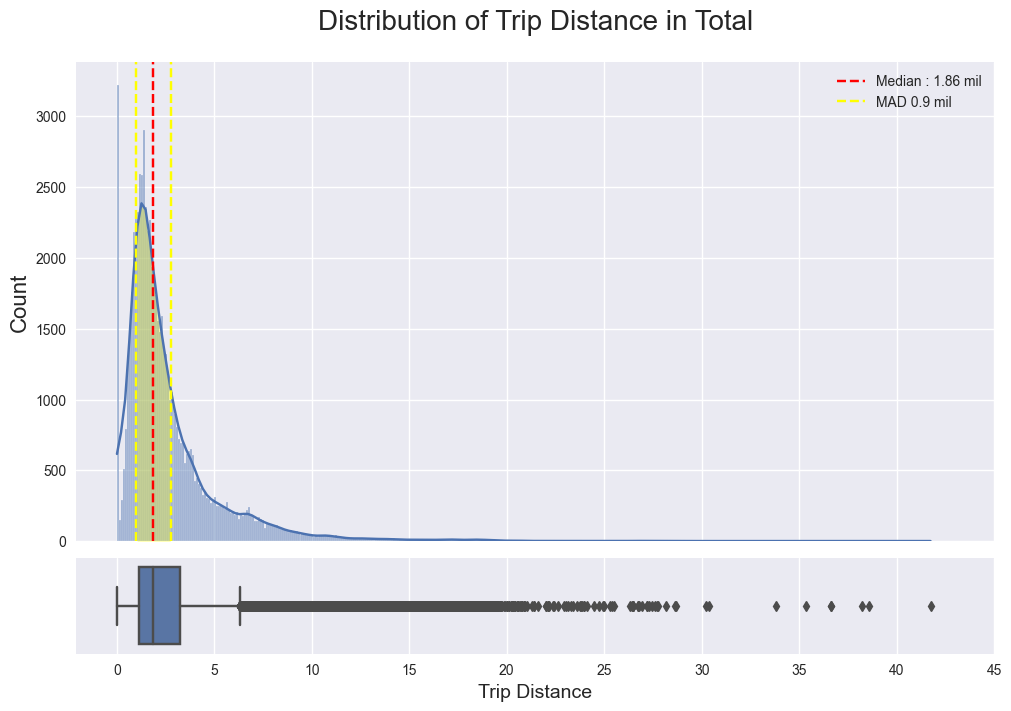

In [103]:
# Cek distribusi jarak trip

# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 7), 
    constrained_layout=True, 
    gridspec_kw={'height_ratios':[5, 1]}, 
    sharex=True
)

# set theme
sns.set_style("whitegrid")

# create distribution distance histogram plot
ax[0] = sns.histplot(
    data=df, 
    x="trip_distance",
    ax=ax[0], 
    kde=True
)
# create distribution distance boxplot
sns.boxplot(
    data=df, 
    x="trip_distance", 
    ax=ax[1]
)

# create tendencies measurement lines
kde_x, kde_y = ax[0].lines[0].get_data()
ax[0].axvline(x=df.trip_distance.median(), color="red", linestyle="--", label=f"Median : {df.trip_distance.median()} mil")
ax[0].axvline(x=df.trip_distance.median() + abs(df.trip_distance - df.trip_distance.median()).median(), color="yellow", linestyle="--", label=f"MAD {abs(df.trip_distance - df.trip_distance.median()).median():0.0} mil")
ax[0].axvline(x=df.trip_distance.median() - abs(df.trip_distance - df.trip_distance.median()).median(), color="yellow", linestyle="--")
ax[0].fill_between(
    kde_x, 
    kde_y, 
    where=(kde_x > df.trip_distance.median() - abs(df.trip_distance - df.trip_distance.median()).median()) & (kde_x < df.trip_distance.median() + abs(df.trip_distance - df.trip_distance.median()).median()), 
    color='yellow', 
    alpha=0.3
)

# set graph attribute
# histogram plot
ax[0].set_title("Distribution of Trip Distance in Total", fontsize=20, y=1.05)
ax[0].set_xlabel("Trip Distance", fontsize=16)
ax[0].set_ylabel("Count", fontsize=16)
ax[0].legend()
# box plot
ax[1].set_xlabel("Trip Distance", fontsize=14)
ax[1].set_xticks(np.arange(0, 50, 5))

# show the plot
plt.show()

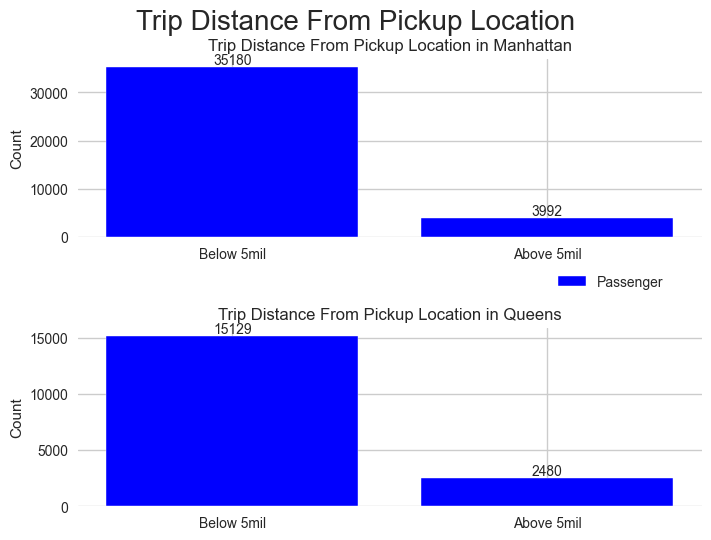

In [104]:
# Cek proporsi trip dibawah 5mil, dan diatas 5mil

# Bikin dataframe untuk kelompokan tripdistance dibawah dan diatas 5mil
TD_Manhattan_Up = len(df[(df.PU_Borough=="Manhattan") & (df.trip_distance>5)])
TD_Manhattan_Below = len(df[(df.PU_Borough=="Manhattan") & (df.trip_distance<=5)])
d = {"Ket": ["Below 5mil", "Above 5mil"], "Count": [TD_Manhattan_Below, TD_Manhattan_Up]}
TD_Manhattan = pd.DataFrame(data=d)
TD_Queens_Up = len(df[(df.PU_Borough=="Queens") & (df.trip_distance>5)])
TD_Queens_Below = len(df[(df.PU_Borough=="Queens") & (df.trip_distance<=5)])
d = {"Ket": ["Below 5mil", "Above 5mil"], "Count": [TD_Queens_Below, TD_Queens_Up]}
TD_Queens = pd.DataFrame(data=d)

# create figure and axes for plot data
fig, ax = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(7,5), 
    constrained_layout=True, 
    sharex=True
)

# Trip Distance from Manhattan
ax1 = plt.subplot2grid((2,1), (0,0));
ax1.bar(
    TD_Manhattan["Ket"],
    TD_Manhattan["Count"], color="Blue"
)
ax1.set_title("Trip Distance From Pickup Location in Manhattan")
ax1.set_ylabel("Count")
plt.xticks(rotation=0)


# Trip Distance from Queens
ax3 = plt.subplot2grid((2,1), (1,0));
ax3.bar(
    TD_Queens["Ket"],
    TD_Queens["Count"], color="Blue"
)
ax3.set_title("Trip Distance From Pickup Location in Queens")
ax3.set_ylabel("Count")
plt.xticks(rotation=0)

plt.suptitle("Trip Distance From Pickup Location", fontsize=20, y=1.05)
plt.legend(["Passenger"], bbox_to_anchor =(0.75, 1.15), loc=3)

# Annotation
ax1.bar_label(ax1.containers[0]);
ax3.bar_label(ax3.containers[0]);

plt.show();

Dari dua grafik diatas kita bisa mendapatkan informasi data trip distance berdistribusi tidak normal (Skewed kanan), maka dari itu kita bisa menggunakan median dan MAD sebagai ukuran pemusatan data, dengan nilai Median == 1.86mil dan MAD == 0.9mil. Untuk meyakinkan kembali, pada grafik dibawahnya menunjukan bahwa untuk setiap kota bagian baik Manhattan maupun Queens memiliki jumlah trip dibawah 5mil terbanyak dibanding trip dengan jarak diatas 5mil. Hal ini terjadi karena masyarakat kota New York akan memilih taksi jika rute perjalanan mereka dekat saja karena mereka mempertimbangkan tarif dasar dan tarif permeter yang ditetapkan oleh pihak penyedia taksi.

##### **- Waktu yang paling sering dipesan?**

In [105]:
df.insert(2, "pickup_date", df.pickup_datetime.apply(lambda x: x.strftime("%d")).astype('object'))
df.insert(3, "pickup_day", df.pickup_datetime.apply(lambda x: x.strftime("%a")).astype('object'))
df.insert(4, "pickup_day_category", np.where(df.pickup_day.isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri']), 'Weekday', 'Weekend').astype('object'))
df.insert(5, "pickup_week", df.pickup_datetime.apply(lambda x: x.strftime("%W")).astype('object'))
df.insert(6, "pickup_hour", df.pickup_datetime.apply(lambda x: x.hour).astype('object'))

<function matplotlib.pyplot.show(close=None, block=None)>

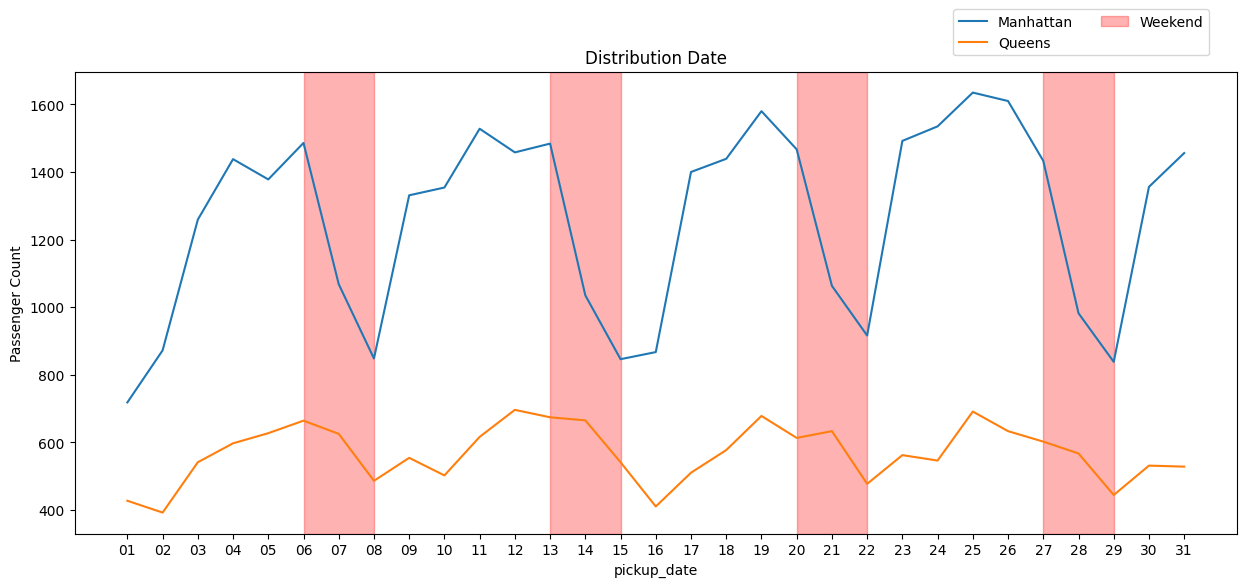

In [106]:
# Buat linechart distribusi waktu

# Create data
df_manhattan = df[df.PU_Borough=="Manhattan"][["pickup_date", "passenger_count"]].groupby("pickup_date").count()
df_queens = df[df.PU_Borough=="Queens"][["pickup_date", "passenger_count"]].groupby("pickup_date").count()
df_brooklyn = df[df.PU_Borough=="Brooklyn"][["pickup_date", "passenger_count"]].groupby("pickup_date").count()

#  set figure size
plt.style.use('default')
plt.figure(figsize=(15,6))

# Distribusi waktu berdasarkan Borough
ax[0] = sns.lineplot(data=df_manhattan, x="pickup_date", y="passenger_count", errorbar=None)
ax[0] = sns.lineplot(data=df_queens, x="pickup_date", y="passenger_count", errorbar=None)
plt.title("Distribution Date")
plt.ylabel("Passenger Count")

# create weekday lines
plt.axvspan(5, 7, alpha=0.3, color='red')
plt.axvspan(12, 14, alpha=0.3, color='red')
plt.axvspan(19, 21, alpha=0.3, color='red')
plt.axvspan(26, 28, alpha=0.3, color='red')

plt.legend(["Manhattan", "Queens", "Weekend"], bbox_to_anchor =(0.75, 1.15), ncol = 2, loc="upper left")

plt.show

Dari grafik diatas dapat diambil insight bahwa baik untuk kota bagian Manhattan maupun Queens selalu mengalami peningkatan di awal minggu dan mengalami penurunan jumlah trip di akhir minggu. Hal ini menandakan bahwa taksi digunakan untuk mobilisasi pengguna di jam 

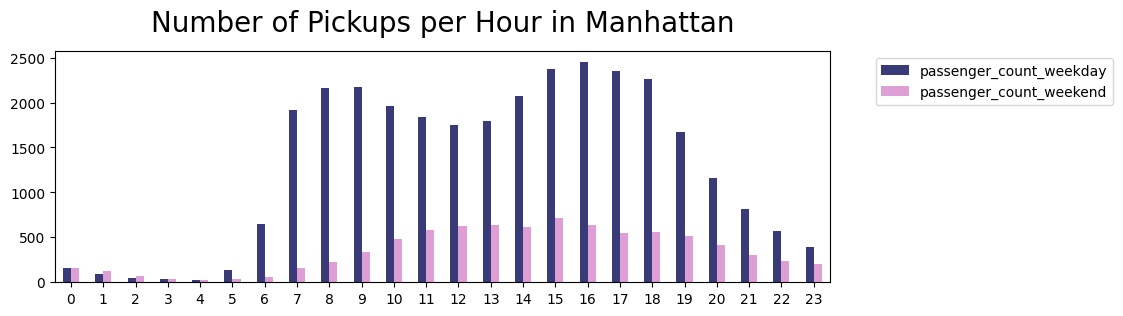

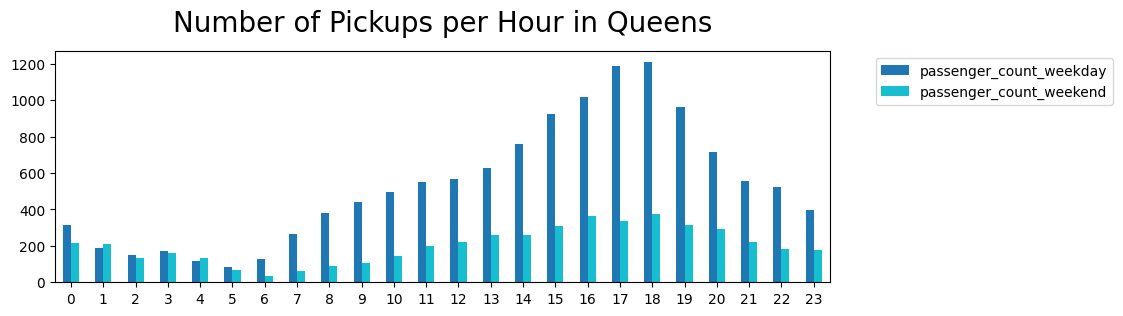

In [107]:
# Cek lokasi dropoff terbanyak untuk trip sesuai dengan lokasi pickupnya

# Create dataframe trip pickup
PH_Manhattan_weekday = df[(df.PU_Borough=="Manhattan") & (df.pickup_day_category=="Weekday")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Manhattan_weekend = df[(df.PU_Borough=="Manhattan") & (df.pickup_day_category=="Weekend")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Manhattan = pd.merge(PH_Manhattan_weekday, PH_Manhattan_weekend, on="pickup_hour").drop(columns="pickup_hour")
PH_Manhattan.rename(columns={"passenger_count_x":"passenger_count_weekday", "passenger_count_y":"passenger_count_weekend"}, inplace=True)

PH_Queens_weekday = df[(df.PU_Borough=="Queens") & (df.pickup_day_category=="Weekday")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Queens_weekend = df[(df.PU_Borough=="Queens") & (df.pickup_day_category=="Weekend")][["pickup_hour", "passenger_count"]].groupby("pickup_hour").count().reset_index()
PH_Queens = pd.merge(PH_Queens_weekday, PH_Queens_weekend, on="pickup_hour").drop(columns="pickup_hour")
PH_Queens.rename(columns={"passenger_count_x":"passenger_count_weekday", "passenger_count_y":"passenger_count_weekend"}, inplace=True)

# plot Trip From Manhattan
ax = PH_Manhattan.plot(kind='bar', figsize=(10, 3), rot=0, colormap="tab20b")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Number of Pickups per Hour in Manhattan", fontsize=20, y=1.05)

# plot Trip From Queens
ax = PH_Queens.plot(kind='bar', figsize=(10, 3), rot=0, colormap="tab10")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Number of Pickups per Hour in Queens", fontsize=20, y=1.05)

plt.show();

##### **- Jenis pembayaran apa yang paling diminati?**

Jenis Pembayaran yang dapat digunakan pada green cabs ini adalah:
* 1=Credit card
* 2=Cash
* 3=No charge
* 4=Dispute
* 5=Unknown 

Kita akan menjawab jenis pembayaran mana yang paling diminati untuk trip dengan pickup di Borough Manhattan dan Queens

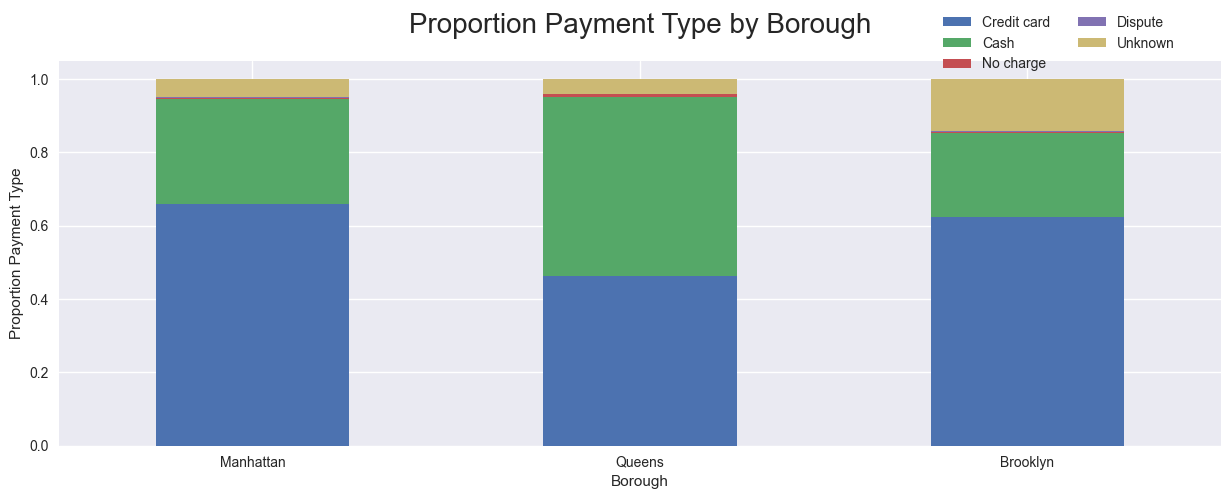

In [108]:
# Proportion Payment Type

payment_ct = pd.crosstab(df["payment_type"], df["PU_Borough"], margins=True)
payment_ct.drop(columns=["Bronx", "Staten Island"],inplace=True)
payment_ct = payment_ct[["Manhattan", "Queens", "Brooklyn"]]
payment_ct = ((payment_ct/payment_ct.iloc[-1])).T
payment_ct.drop(columns=["All"], inplace=True)
plt.style.use("seaborn")
plots = payment_ct.plot(kind="bar", stacked=True, figsize=(15, 5), )

plt.xticks(rotation=0)
plt.xlabel("Borough")
plt.ylabel("Proportion Payment Type")
plt.legend(["Credit card", "Cash", "No charge", "Dispute", "Unknown"], bbox_to_anchor =(0.75, 1.15), ncol = 2, loc="upper left")
plt.xticks(np.arange(len(payment_ct.index.tolist())),payment_ct.index.tolist())
plt.title("Proportion Payment Type by Borough", fontsize=20, y=1.05)

plt.show()

Dapat dilihat dari grafik diatas kita dapat menyimpulkan:
1. Pada lokasi pickup taksi di Manhattan, jenis pembayaran yang paling banyak dilakukan oleh penumpang ialah menggunakan Credit Card sebesar sekitar 70% dan Cash sebesar sekitar 30%
2. Pada lokasi Queens, jenis pembayaran relatif sama antara yang menggunakan Credit Card, maupun Cash, dengan ratio sekitar 50% 

Uji stat apakah ada perbedaan signifikan antar masing2 metoe pembayaran

##### **- Jenis trip yang biasanya dilakukan oleh pengguna taksi?**

Jenis trip yang dapat digunakan pada green cabs ini adalah:
* 1=Street-hail
* 2=Dispatch
* 3=Others 

Kita akan menjawab jenis pembayaran mana yang paling diminati untuk trip dengan pickup di Borough Manhattan dan Queens

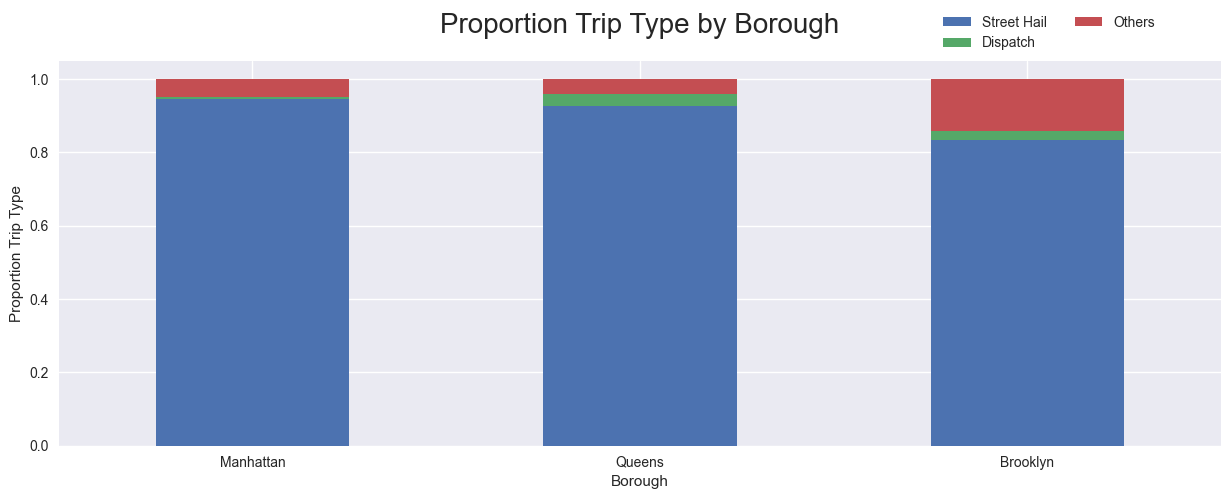

In [109]:
# Proportion Trip Type

trip_ct = pd.crosstab(df["trip_type"], df["PU_Borough"], margins=True)
trip_ct.drop(columns=["Bronx", "Staten Island"],inplace=True)
trip_ct = trip_ct[["Manhattan", "Queens", "Brooklyn"]]
trip_ct = ((trip_ct/trip_ct.iloc[-1])).T
trip_ct.drop(columns=["All"], inplace=True)
plt.style.use("seaborn")
plots = trip_ct.plot(kind="bar", stacked=True, figsize=(15, 5), )

plt.xticks(rotation=0)
plt.xlabel("Borough")
plt.ylabel("Proportion Trip Type")
plt.legend(["Street Hail", "Dispatch", "Others"], bbox_to_anchor =(0.75, 1.15), ncol = 2, loc="upper left")
plt.xticks(np.arange(len(trip_ct.index.tolist())),trip_ct.index.tolist())
plt.title("Proportion Trip Type by Borough", fontsize=20, y=1.05)

plt.show()

### **3. Saran dan Rekomendasi**

Dari analisis yang telah dilakukan, kita dapat membuat kesimpulan sebagai berikut:
* 